# Price Options Using Machine Learning Algorithms

**Jonathan Kinlay, PhD**
<br/>
Intelligent Technologies
<br/>
August 2023

## Abstract

In the intricate world of quantitative finance, the potential of machine learning to predict financial instruments' prices is increasingly evident. This research evaluates various machine learning models in forecasting vanilla put option prices. By generating a dataset rooted in the Black-Scholes model, the Neural Network model displayed outstanding out-of-sample performance, closely trailed by tree-based models.

## Introduction

Options, pivotal in financial markets, serve in risk mitigation, hedging, and speculative strategies. Traditional models, such as Black-Scholes, have been foundational in option pricing. Yet, market evolution challenges the assumptions of these conventional models, ushering in potential pricing discrepancies. 
The advent of machine learning offers a potential avenue to apply these advanced algorithms in option pricing, potentially surpassing classical model limitations.

## Methodology

The approach for this study is outlined in the following steps:

### Data Generation

Emulating real-world scenarios, 100,000 option samples were synthesized, embedding parameters to mirror genuine market characteristics. A pronounced volatility skew, commonly observed for out-of-the-money options, was seamlessly incorporated.

In [1]:

import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
n_samples = 100000

# Generating random parameters for the options
S = np.random.uniform(50, 150, n_samples)  # Spot Price: Between $50 and $150
K = np.random.uniform(50, 150, n_samples)  # Strike Price: Between $50 and $150
T = np.random.uniform(0.25, 2, n_samples)  # Time to Maturity: Between 3 months and 2 years
r = np.random.uniform(0.01, 0.05, n_samples)  # Risk-free Rate: Between 1% and 5%

# Introducing volatility skew: Options with lower strike prices will tend to have higher volatilities
sigma = np.random.uniform(0.1, 0.4, n_samples) + (K < S) * np.random.uniform(0.05, 0.15, n_samples)

# Creating a DataFrame to store these values
options_df = pd.DataFrame({
    'Spot_Price': S,
    'Strike_Price': K,
    'Time_to_Maturity': T,
    'Risk_free_Rate': r,
    'Volatility': sigma
})

options_df.head()
    

,Spot_Price,Strike_Price,Time_to_Maturity,Risk_free_Rate,Volatility
0,87.454012,108.077904,0.744529,0.016282,0.366686
1,145.071431,102.697165,1.052684,0.013820,0.295664
2,123.199394,85.103695,0.423627,0.015518,0.229967
3,109.865848,99.321266,1.031965,0.028940,0.525141
4,65.601864,86.509664,0.605392,0.045381,0.230878


### Option Pricing

Next, we'll use the Black-Scholes formula to compute the put option prices for each of these parameter sets.

In [8]:

from scipy.stats import norm

def black_scholes_put_price(S, K, T, r, sigma, q=0):
    """
    Compute the Black-Scholes put option price.
    
    Parameters:
    - S: Spot price of the underlying asset
    - K: Strike price of the option
    - T: Time to maturity (in years)
    - r: Risk-free interest rate (annualized)
    - sigma: Volatility of the underlying asset (annualized)
    - q: Dividend yield (annualized). Default is 0 (no dividends).
    
    Returns:
    - Put option price
    """
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)
    return put_price

# Compute put option prices using Black-Scholes formula
options_df['BS_Put_Price'] = black_scholes_put_price(
    options_df['Spot_Price'], 
    options_df['Strike_Price'], 
    options_df['Time_to_Maturity'], 
    options_df['Risk_free_Rate'], 
    options_df['Volatility']
)
options_df[['Spot_Price', 'Strike_Price', 'Volatility', 'Adjusted_Volatility', 'BS_Put_Price']].head()

,Spot_Price,Strike_Price,Volatility,Adjusted_Volatility,BS_Put_Price
0,87.454012,108.077904,0.366686,0.366686,24.191026
1,145.071431,102.697165,0.295664,0.370170,2.102809
2,123.199394,85.103695,0.229967,0.254898,0.029113
3,109.865848,99.321266,0.525141,0.545787,15.590019
4,65.601864,86.509664,0.230878,0.230878,19.065520


### Volatility Skew Adjustment

The volatility skew is a phenomenon where out-of-the-money (OTM) options tend to have higher implied volatilities compared to at-the-money (ATM) or in-the-money (ITM) options. This skew is often more pronounced for options with lower strike prices.

To implement a more pronounced skew, I'll adjust the volatility based on:

1. How far OTM the option is.
2. The magnitude of the strike price.

In [4]:
# Adjusting the volatility skew based on how far OTM the option is and the magnitude of the strike price
delta_from_ATM = (options_df['Spot_Price'] - options_df['Strike_Price']).abs()
skew_factor = np.where(options_df['Strike_Price'] < options_df['Spot_Price'], delta_from_ATM / options_df['Strike_Price'], 0)

# Adjusting the volatility to introduce a more pronounced skew for OTM options and options with smaller strike prices
options_df['Adjusted_Volatility'] = options_df['Volatility'] + skew_factor * np.random.uniform(0.05, 0.2, n_samples)

# Compute put option prices using Black-Scholes formula with adjusted volatility
options_df['BS_Put_Price'] = black_scholes_put_price(
    options_df['Spot_Price'], 
    options_df['Strike_Price'], 
    options_df['Time_to_Maturity'], 
    options_df['Risk_free_Rate'], 
    options_df['Adjusted_Volatility']
)

options_df[['Spot_Price', 'Strike_Price', 'Volatility', 'Adjusted_Volatility', 'BS_Put_Price', 'Adjusted_BS_Put_Price']].head()


,Spot_Price,Strike_Price,Volatility,Adjusted_Volatility,BS_Put_Price,Adjusted_BS_Put_Price
0,87.454012,108.077904,0.366686,0.366686,24.191026,24.191026
1,145.071431,102.697165,0.295664,0.370170,4.183218,2.967925
2,123.199394,85.103695,0.229967,0.254898,0.067591,0.273305
3,109.865848,99.321266,0.525141,0.545787,16.396201,16.073277
4,65.601864,86.509664,0.230878,0.230878,19.065520,19.065520


### Data Splitting

We'll split the generated data into training and testing sets. This ensures that the machine learning models are evaluated on unseen data, providing a more realistic assessment of their predictive capabilities.

In [9]:

from sklearn.model_selection import train_test_split

# Features and target variable
X = options_df[['Spot_Price', 'Strike_Price', 'Time_to_Maturity', 'Risk_free_Rate', 'Volatility']]
y = options_df['Adjusted_BS_Put_Price']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape, X_test.shape
    

((80000, 5), (20000, 5))

## Machine Learning Models

### Linear Regression Model

We'll begin by training and evaluating a Linear Regression model on our dataset. This model will serve as a baseline, and its performance metrics will be used for comparison with more complex models.

In [10]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Predict on the test set
lr_predictions = lr_model.predict(X_test)

# Compute accuracy metrics
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_mae = mean_absolute_error(y_test, lr_predictions)
lr_r2 = r2_score(y_test, lr_predictions)

lr_mse, lr_mae, lr_r2
    

(82.30656235679855, 7.410646174896283, 0.8020023793175672)

### Decision Tree Regressor

Next, we'll explore a Decision Tree Regressor. Decision Trees can capture non-linear relationships in the data and might offer better performance than the linear model. Let's train, predict, and evaluate the model.

In [11]:

from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor model
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on the test set
dt_predictions = dt_model.predict(X_test)

# Compute accuracy metrics
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)

dt_mse, dt_mae, dt_r2
    

(2.224022611312335, 1.0998208871027149, 0.9946498654205135)

### Random Forest Regressor

We'll now utilize the Random Forest Regressor. Random Forests, being an ensemble of decision trees, can often capture more intricate patterns in the data, providing potentially better predictive power than individual trees. Let's proceed with its training, prediction, and evaluation.

In [12]:

from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Compute accuracy metrics
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

rf_mse, rf_mae, rf_r2
    

(0.6236407962069487, 0.5833766515370907, 0.9984997624700422)

### Gradient Boosted Trees Regressor

We'll now implement the Gradient Boosted Trees Regressor. Gradient Boosting is a powerful ensemble technique that can provide high accuracy by iteratively correcting errors from previous trees. Let's train, predict, and evaluate this model.

In [15]:

from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Predict on the test set
gb_predictions = gb_model.predict(X_test)

# Compute accuracy metrics
gb_mse = mean_squared_error(y_test, gb_predictions)
gb_mae = mean_absolute_error(y_test, gb_predictions)
gb_r2 = r2_score(y_test, gb_predictions)

gb_mse, gb_mae, gb_r2
    

(3.012747541165223, 1.3659705360230647, 0.9927524995846423)

### Neural Network (MLP) Regressor

Lastly, we'll employ a Neural Network model. Neural Networks can capture complex non-linear relationships in data and are particularly suited for large datasets. Before training the model, we'll scale our features since neural networks perform better with standardized input data.

In [13]:

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Neural networks benefit from feature scaling. So, we'll scale our features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Neural Network (MLP) model
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

# Train the model
nn_model.fit(X_train_scaled, y_train)

# Predict on the test set
nn_predictions = nn_model.predict(X_test_scaled)

# Compute accuracy metrics
nn_mse = mean_squared_error(y_test, nn_predictions)
nn_mae = mean_absolute_error(y_test, nn_predictions)
nn_r2 = r2_score(y_test, nn_predictions)

nn_mse, nn_mae, nn_r2
    

(0.11641604855765736, 0.2004961190592006, 0.9997199482038414)

## Summary of Model Performance

The table below provides a concise summary of each model's performance on the test data. These metrics allow us to compare and assess the efficacy of each model in predicting vanilla put option prices.

In [16]:

import pandas as pd

# Constructing the results dataframe
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosted Trees', 'Neural Network (MLP)'],
    'Mean Squared Error': [lr_mse, dt_mse, rf_mse, gb_mse, nn_mse],
    'Mean Absolute Error': [lr_mae, dt_mae, rf_mae, gb_mae, nn_mae],
    'R-squared': [lr_r2, dt_r2, rf_r2, gb_r2, nn_r2]
})

results_df


,Model,Mean Squared Error,Mean Absolute Error,R-squared
0,Linear Regression,82.306562,7.410646,0.802002
1,Decision Tree,2.224023,1.099821,0.994650
2,Random Forest,0.623641,0.583377,0.998500
3,Gradient Boosted Trees,3.012748,1.365971,0.992752
4,Neural Network (MLP),0.116416,0.200496,0.999720


### Scatter Plots of Actual vs. Predicted Option Prices

The scatter plots below visualize the actual versus the predicted option prices for each model. A red dashed line represents the ideal scenario where the predicted price matches the actual price. Deviations from this line indicate prediction errors.

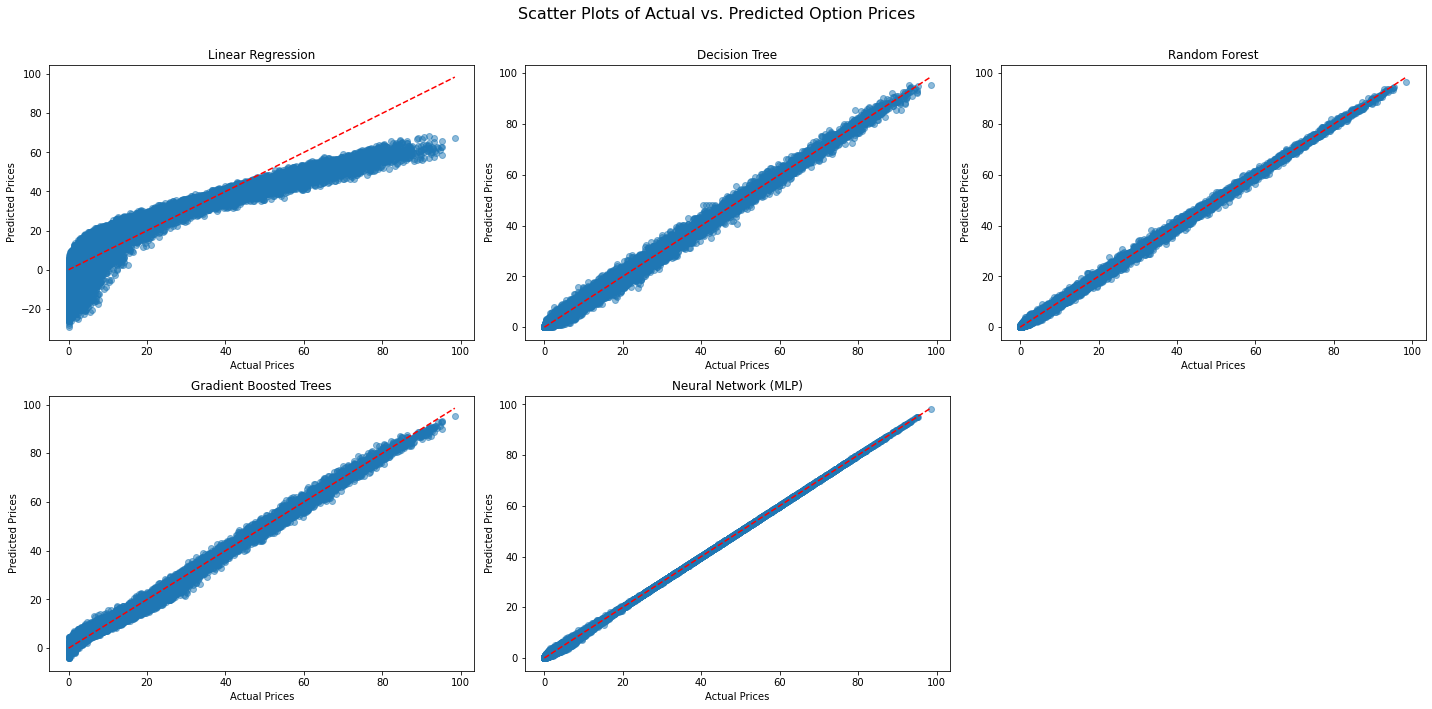

In [24]:

import matplotlib.pyplot as plt

# Set up the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle('Scatter Plots of Actual vs. Predicted Option Prices', fontsize=16)

# Linear Regression Scatter Plot
axs[0, 0].scatter(y_test, lr_predictions, alpha=0.5)
axs[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axs[0, 0].set_title('Linear Regression')
axs[0, 0].set_xlabel('Actual Prices')
axs[0, 0].set_ylabel('Predicted Prices')

# Decision Tree Scatter Plot
axs[0, 1].scatter(y_test, dt_predictions, alpha=0.5)
axs[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axs[0, 1].set_title('Decision Tree')
axs[0, 1].set_xlabel('Actual Prices')
axs[0, 1].set_ylabel('Predicted Prices')

# Random Forest Scatter Plot
axs[0, 2].scatter(y_test, rf_predictions, alpha=0.5)
axs[0, 2].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axs[0, 2].set_title('Random Forest')
axs[0, 2].set_xlabel('Actual Prices')
axs[0, 2].set_ylabel('Predicted Prices')

# Gradient Boosted Trees Scatter Plot
axs[1, 0].scatter(y_test, gb_predictions, alpha=0.5)
axs[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axs[1, 0].set_title('Gradient Boosted Trees')
axs[1, 0].set_xlabel('Actual Prices')
axs[1, 0].set_ylabel('Predicted Prices')

# Neural Network Scatter Plot
axs[1, 1].scatter(y_test, nn_predictions, alpha=0.5)
axs[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')
axs[1, 1].set_title('Neural Network (MLP)')
axs[1, 1].set_xlabel('Actual Prices')
axs[1, 1].set_ylabel('Predicted Prices')

# Hide the empty subplot
axs[1, 2].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


## Discussion

A few observations emerge:
<br/>
1. Neural Network's Superiority: The Neural Network's remarkable performance highlights the potential of deep learning techniques in the realm of financial modeling. Its near-perfect predictions underscore its capacity to capture complex nonlinear relationships inherent in option pricing.    

<br/>

2. Tree-based Models: While the Neural Network stood out, tree-based models, particularly the Random Forest, showcased impressive predictive abilities. These models offer the advantage of better interpretability, making them invaluable in scenarios where understanding model decisions is pivotal.  

<br/>

3. Linear Regression's Limitations: Linear Regression, though foundational, struggled to capture the complexities of option pricing, evident from its lower R2 value compared to other models. This suggests that the relationships in the data might be inherently nonlinear, necessitating more intricate models.


## Conclusion

This research underscores the potential of machine learning models, especially deep learning, in the realm of option pricing. Their ability to model intricate relationships and adapt to complex data structures makes them compelling candidates for financial modeling. However, while these models show promise, practitioners must exercise caution. Thorough validation on real-world data and a comprehensive understanding of model intricacies and limitations are imperative before deploying them in live financial scenarios.


## References

1. Black, F., Scholes, M. (1973). The Pricing of Options and Corporate Liabilities. Journal of Political Economy. 
<br/>

2. Hull, J. (2017). Options, Futures, and Other Derivatives. Pearson. 
<br/>

3. Rubinstein, M. (1994). Implied Binomial Trees. The Journal of Finance.
<br/>

4. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An Introduction to Statistical Learning. Springer.
<br/>

5. Hyndman, R.J., Koehler, A.B. (2006). Another look at measures of forecast accuracy. International Journal of Forecasting.
<br/>
6. Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press. 
<br/>
7. Breiman, L. (2001). Random Forests. Machine Learning. 



In [1]:
import os
print(os.getcwd())

C:\Users\jkinlay
